In [2]:
import numpy as np
import pandas as pd
import mosqlient as mosq
from epiweeks import Week
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os
load_dotenv()  # by default, it looks for a file named ".env" in the current directory

# Access variables
api_key = os.getenv("API_KEY")


Load the dengue data available at FTP do sprint:

In [3]:
data = pd.read_csv('/Users/eduardoaraujo/Documents/sprint_data_2025/dengue.csv.gz')
data.date = pd.to_datetime(data.date)
data = data.groupby(['date', 'uf'])[['casos']].sum().reset_index()
data = data.sort_values(by = 'date')
data.head()

,date,uf,casos
0,2010-01-03,AC,760
26,2010-01-03,TO,231
25,2010-01-03,SP,1628
24,2010-01-03,SE,3
23,2010-01-03,SC,10


Valid date interval accordingo to the sprint rules: 

In [4]:
ref_dates_23 = set(pd.date_range(start= Week(2022, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2023, 40).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN'))

ref_dates_24 = set(pd.date_range(start= Week(2023, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2024, 40).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN'))

ref_dates_25 = set(pd.date_range(start= Week(2024, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2025, 40).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN'))

ref_dates_26 = set(pd.date_range(start= Week(2025, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2026, 40).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN'))

Get the predictions for a specific model:

In [5]:
preds = mosq.get_predictions(api_key=api_key, model_id=154)

100%|█████████████████████████████████████| 2/2 [00:02<00:00,  1.25s/requests]


In [6]:
len(preds)

81

Validate the predictions: 

In [7]:
df_predictions = pd.DataFrame()

for pred_ in preds:

    preds_df = pred_.to_dataframe()

    preds_df.date = pd.to_datetime(preds_df.date)

    min_date = min(preds_df.date)
    
    max_date = max(preds_df.date)

    df_dates = set(preds_df.date)

    if min_date.year == 2022:
        ref_dates = ref_dates_23
        valid_test = 1 
        
    elif min_date.year == 2023:
        ref_dates = ref_dates_24
        valid_test = 2

    elif min_date.year == 2024:
        ref_dates = ref_dates_25
        valid_test = 3

    elif min_date.year == 2025:
        ref_dates = ref_dates_26
        valid_test = 'Forecast'

    missing_dates = ref_dates - df_dates
    extra_dates = df_dates - ref_dates
    
    if len(missing_dates) == 0:
        valid = True 
    else: 
        valid = False

    tem_zero = (preds_df[['lower_95', 'lower_90', 'lower_80', 'lower_50', 'pred',
       'upper_50', 'upper_80', 'upper_90', 'upper_95']] == 0).any().any()

    tem_negativo = ~(preds_df[['lower_95', 'lower_90', 'lower_80', 'lower_50', 'pred',
       'upper_50', 'upper_80', 'upper_90', 'upper_95']] < 0).any().any()

    quantile_order_strict = (
    (preds_df['lower_95'] < preds_df['lower_90']) &
    (preds_df['lower_90'] < preds_df['lower_80']) &
    (preds_df['lower_80'] < preds_df['lower_50']) &
    (preds_df['lower_50'] < preds_df['pred']) &
    (preds_df['pred']     < preds_df['upper_50']) &
    (preds_df['upper_50'] < preds_df['upper_80']) &
    (preds_df['upper_80'] < preds_df['upper_90']) &
    (preds_df['upper_90'] < preds_df['upper_95'])
    )

    quantile_order = (
    (preds_df['lower_95'] <= preds_df['lower_90']) &
    (preds_df['lower_90'] <= preds_df['lower_80']) &
    (preds_df['lower_80'] <= preds_df['lower_50']) &
    (preds_df['lower_50'] <= preds_df['pred']) &
    (preds_df['pred']     <= preds_df['upper_50']) &
    (preds_df['upper_50'] <= preds_df['upper_80']) &
    (preds_df['upper_80'] <= preds_df['upper_90']) &
    (preds_df['upper_90'] <= preds_df['upper_95'])
    )
     
    df_predictions = pd.concat([df_predictions, 
                              pd.DataFrame(
                                  [[ pred_.id, 
                                    preds_df.shape[0], 
                                    min_date, 
                                    max_date, 
                                    pred_.dict()['adm_1'],
                                    tem_zero,
                                   tem_negativo,
                                    quantile_order.all(),
                                   quantile_order_strict.all(), 
                                   valid_test,
                                   valid, len(missing_dates), len(extra_dates)]], 
                                  columns = ['id',
                                             'size', 
                                            'start_date',
                                            'end_date', 'state', 
                                            'zero_values','nonnegative', 'q_order', 'qorder_stric',
                                            'validation_test', 'valid', 'missing_dates', 'extra_dates']) ], ignore_index = True)



The predictions are considered valid only if:

1 - The submitted dates are within the correct range: valid = True

2 - The submitted quantiles are correctly ordered: q_order = True

3 - There are no negative values: nonnegative = True

The cell below shows the number of predictions submitted for each validation. A minimum of 26 is expected (since submission for ES was not mandatory).

In [8]:
df_predictions = df_predictions.loc[df_predictions.state != 'ES']

In [9]:
df_predictions.loc[(df_predictions.valid == True) & (df_predictions.q_order== True) & (df_predictions.nonnegative == True)].validation_test.value_counts()

validation_test
3    26
2    26
1    26
Name: count, dtype: int64

In [10]:
df_predictions.validation_test.value_counts()

validation_test
3    26
2    26
1    26
Name: count, dtype: int64

The cell below indicates whether any duplicate predictions were submitted:

In [11]:
df_valid = df_predictions.loc[(df_predictions.valid == True) & (df_predictions.q_order== True) & (df_predictions.nonnegative == True)]

df_dup = (
    df_valid
    .groupby(['state', 'validation_test'])['id']
    .agg(n_unique_ids='nunique', ids=lambda x: sorted(x.unique()))
    .reset_index()
)
df_dup['min_id'] = df_dup['ids'].apply(lambda x: min(x))

print(df_dup.loc[df_dup.n_unique_ids>1].shape)
df_dup.loc[df_dup.n_unique_ids>1]

(0, 5)


,state,validation_test,n_unique_ids,ids,min_id


In [12]:
df_dup.loc[df_dup.n_unique_ids>1].min_id.values

array([], dtype=int64)

Predictions with something wrong:

In [13]:
df_predictions.loc[(df_predictions.valid == False) | (df_predictions.q_order== False) | (df_predictions.nonnegative == False)].id.values

array([], dtype=int64)

In [14]:
df_predictions.loc[(df_predictions.valid == False) | (df_predictions.q_order== False) | (df_predictions.nonnegative == False)]

,id,size,start_date,end_date,state,zero_values,nonnegative,q_order,qorder_stric,validation_test,valid,missing_dates,extra_dates


Plot the predictions:

In [15]:
dates_23 = pd.date_range(start= Week(2022, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2023, 40).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

dates_24 = pd.date_range(start= Week(2023, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2024, 40).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

dates_25 = pd.date_range(start= Week(2024, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2025, 40).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

def plot_by_state(state):

    data_state = data.loc[data.uf == state]

    val_1_id = df_predictions.loc[(df_predictions.state == state) & (df_predictions.validation_test == 1)].sort_values(by='id').id.values[-1]
    val_2_id = df_predictions.loc[(df_predictions.state == state) & (df_predictions.validation_test == 2)].sort_values(by='id').id.values[-1]
    val_3_id = df_predictions.loc[(df_predictions.state == state) & (df_predictions.validation_test == 3)].sort_values(by='id').id.values[-1]
    
    df_pred_1 = mosq.get_prediction_by_id(api_key = api_key, id = val_1_id).to_dataframe()
    
    df_pred_2 = mosq.get_prediction_by_id(api_key = api_key, id = val_2_id).to_dataframe()
    
    df_pred_3 = mosq.get_prediction_by_id(api_key = api_key, id = val_3_id).to_dataframe()

    _,ax = plt.subplots(1,3, figsize = (18, 4), sharey = True)

    for ax_, df_pred_, title, dates_ in zip(ax.ravel(), [df_pred_1, df_pred_2, df_pred_3],
                                    ['Validaton test 1', 'Validation test 2', 'Validation_test_3'],
                                           [dates_23, dates_24, dates_25]):
    
        data_ = data_state.loc[data_state.date.isin(dates_)]
    
        df_pred_.date = pd.to_datetime(df_pred_.date)
    
        ax_.plot(data_.date, data_.casos , marker='o', linestyle='', label='Data', color = 'black')
    
        ax_.plot(df_pred_.date, df_pred_.pred, color = 'tab:orange', label = 'Model')
    
        for alpha in [50, 80, 90, 95]: 
    
            ax_.fill_between(df_pred_.date, df_pred_[f'lower_{alpha}'], df_pred_[f'upper_{alpha}'], color = 'tab:orange', 
                            alpha = 0.1)
    
        ax_.grid()
    
        ax_.set_title(title)
    
    ax[0].legend()
    
    plt.suptitle(f'Predictions for {state}')
    
    plt.tight_layout()
        
    plt.show()
    
        
        

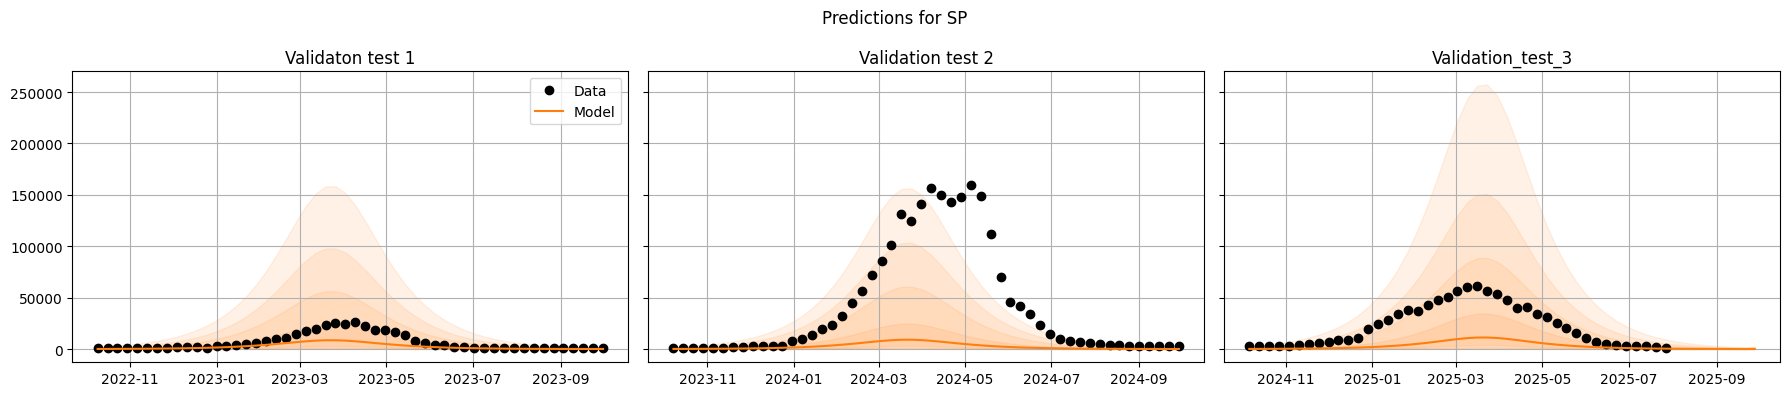

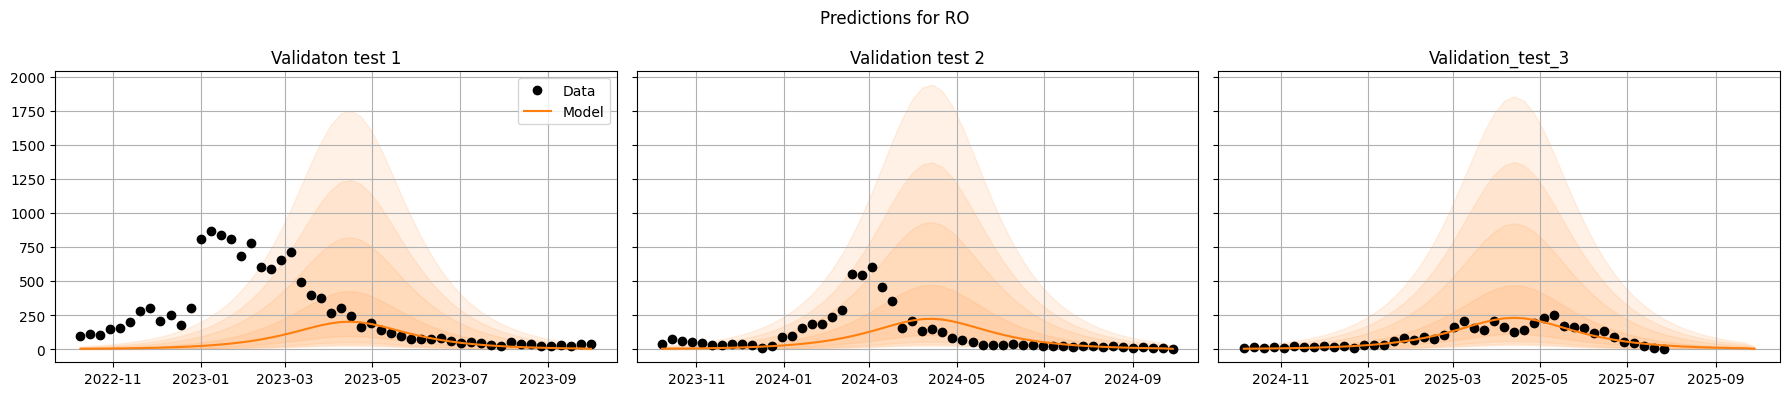

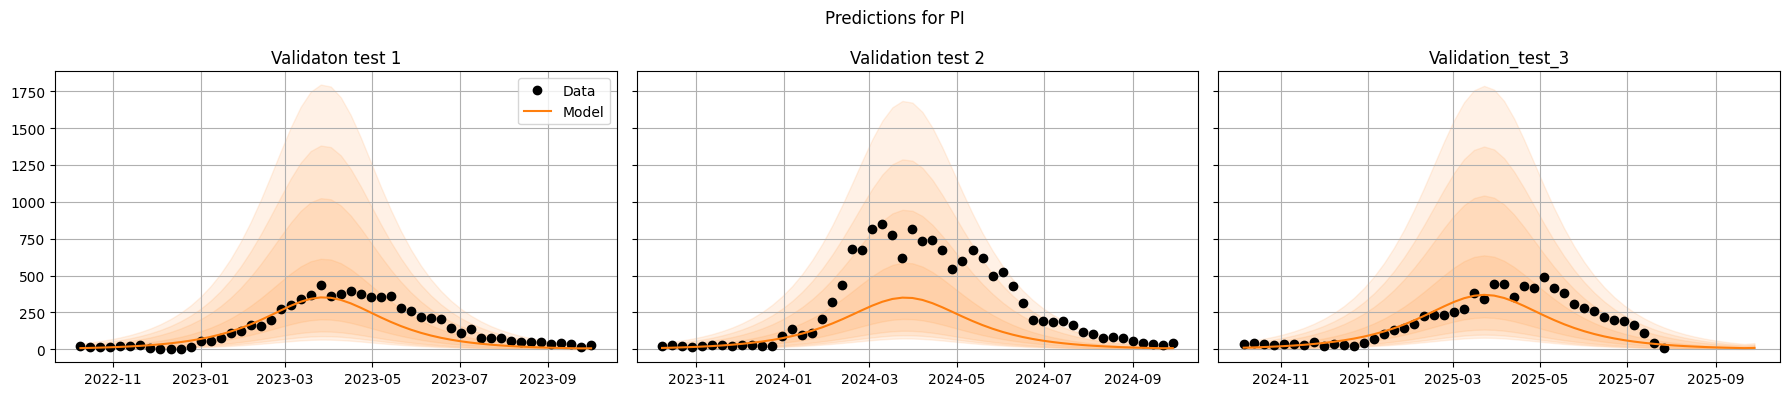

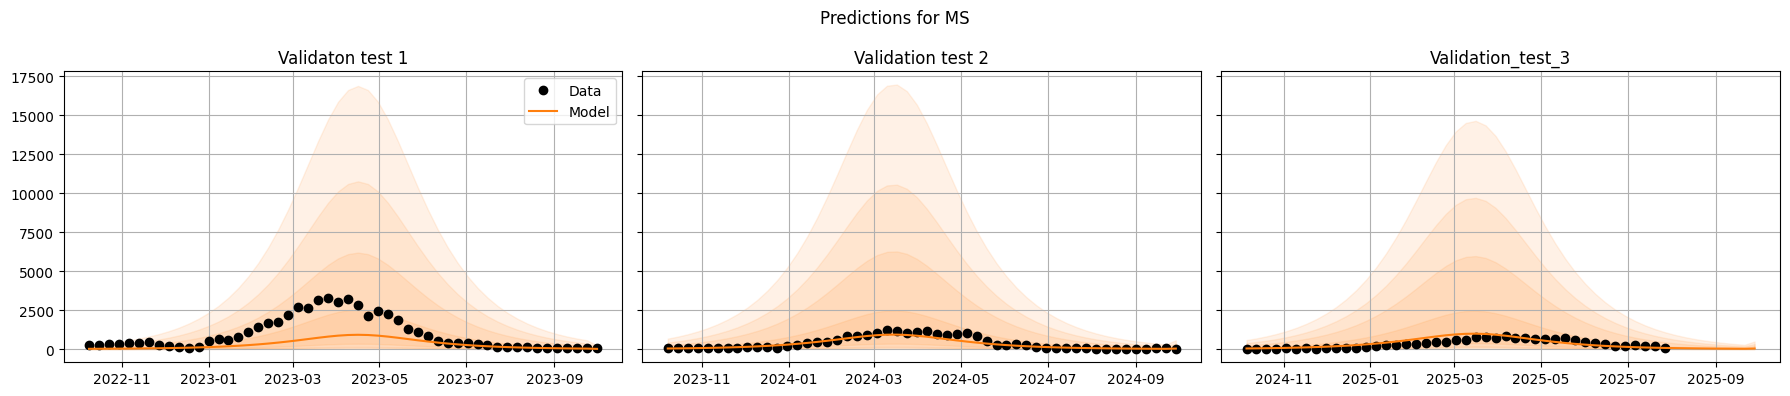

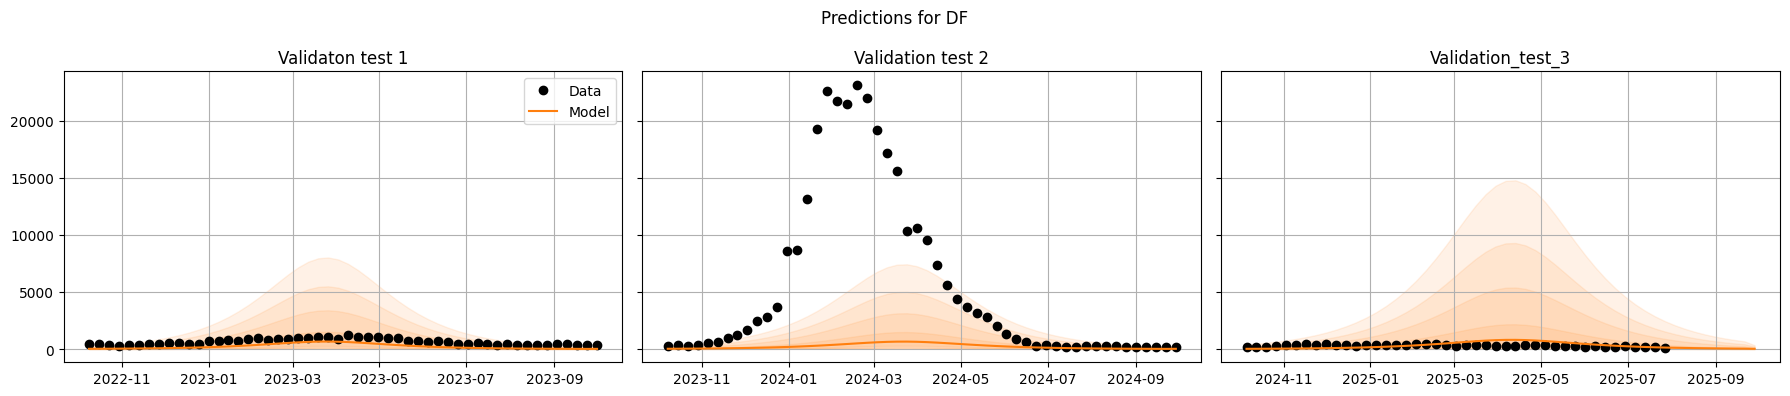

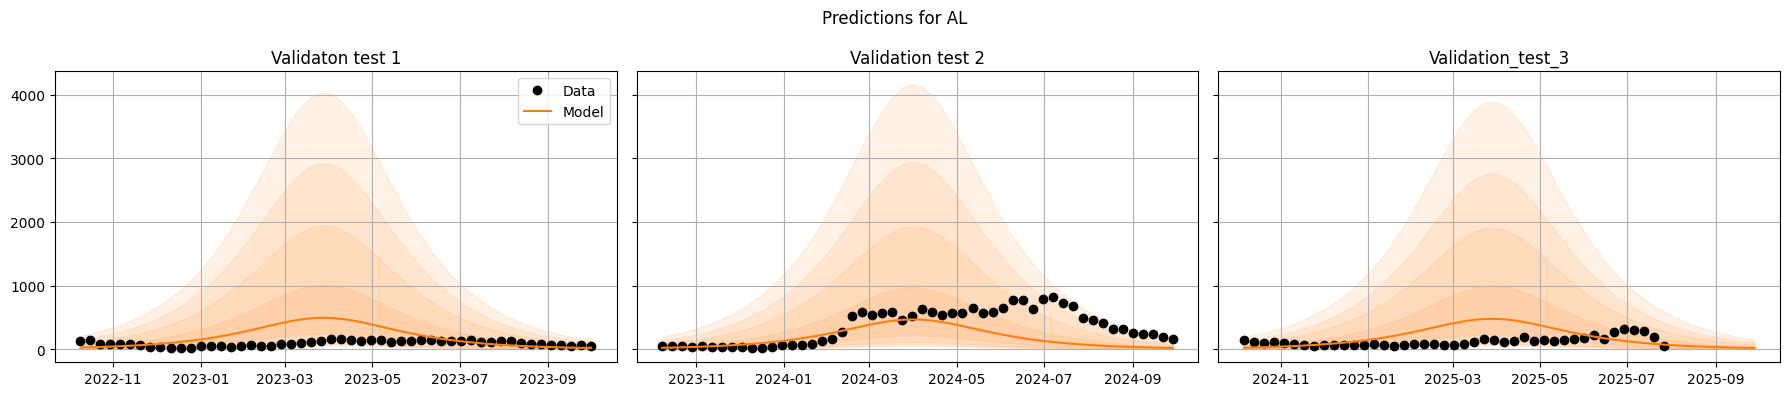

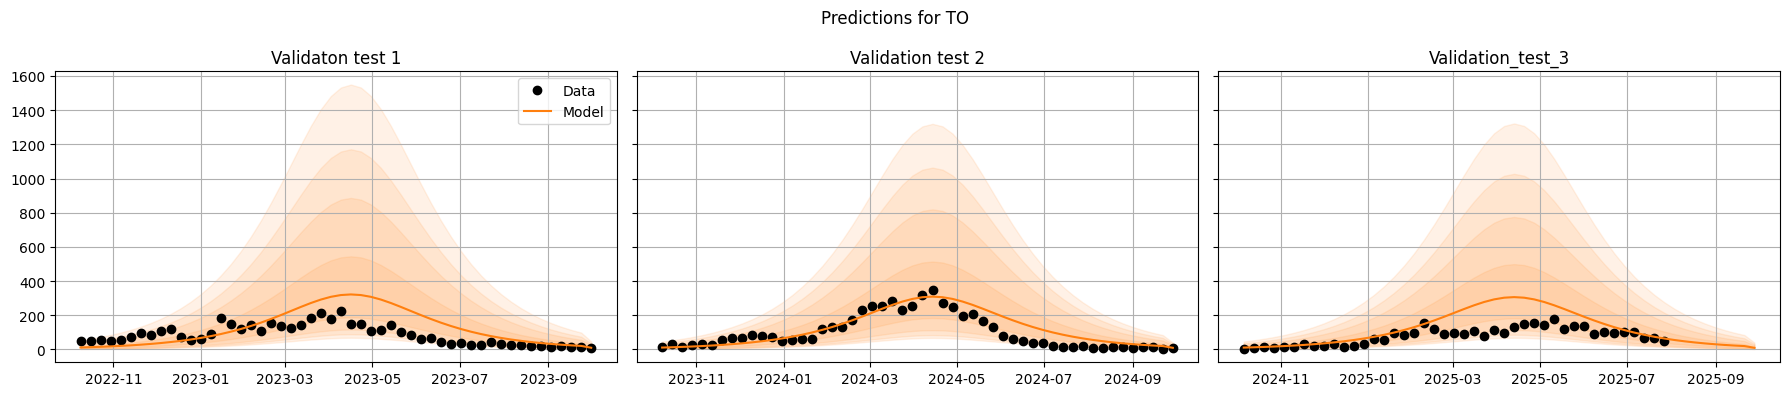

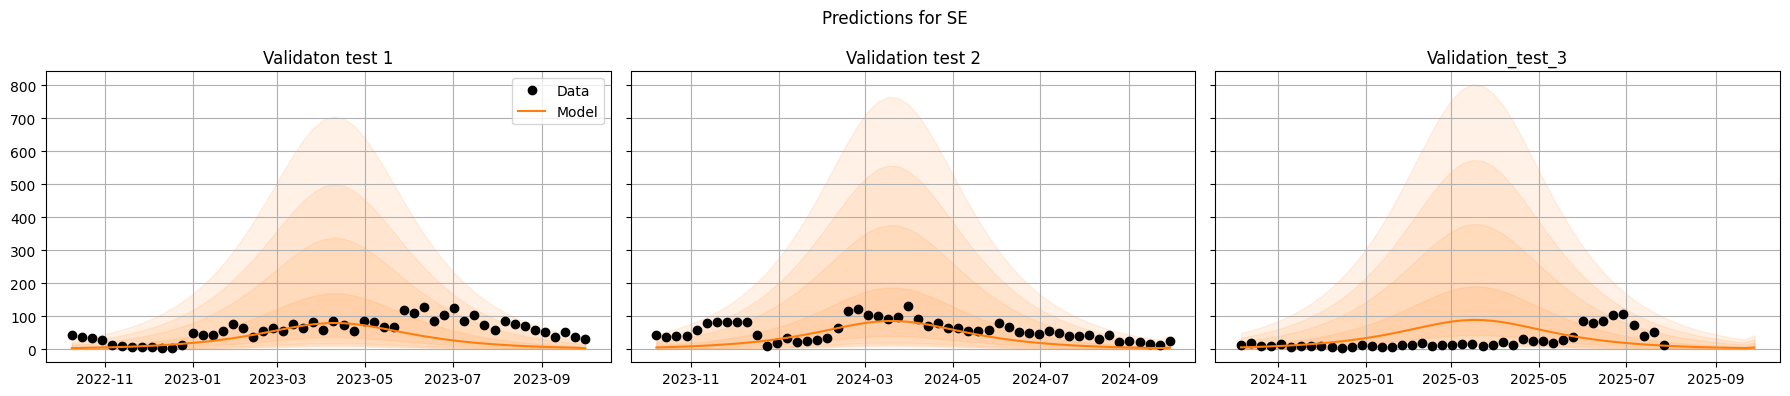

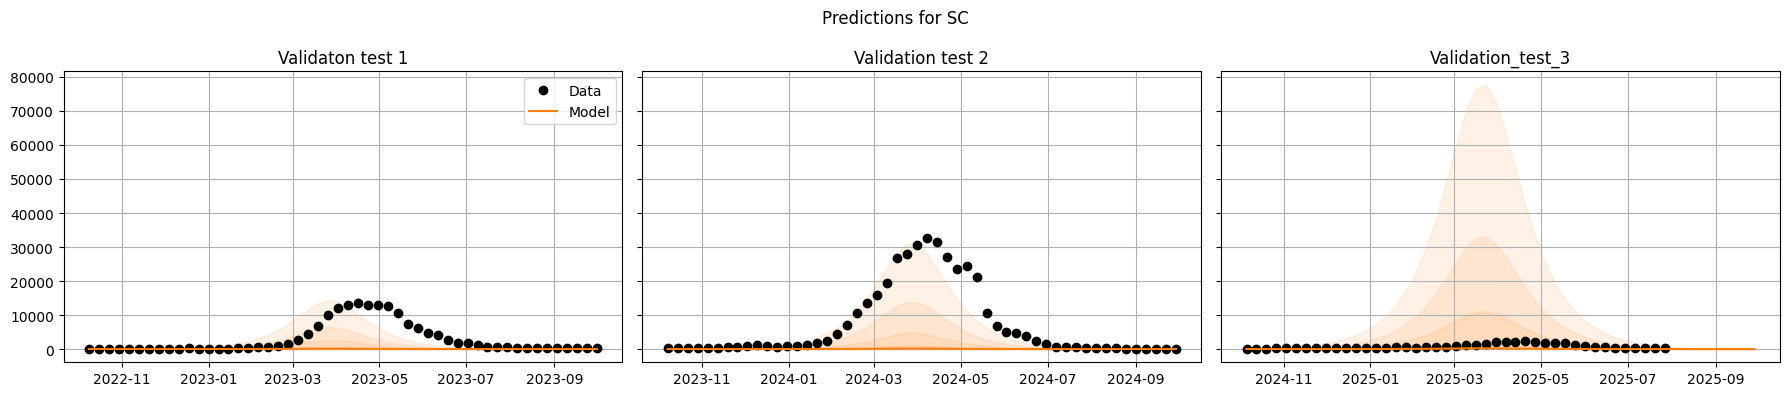

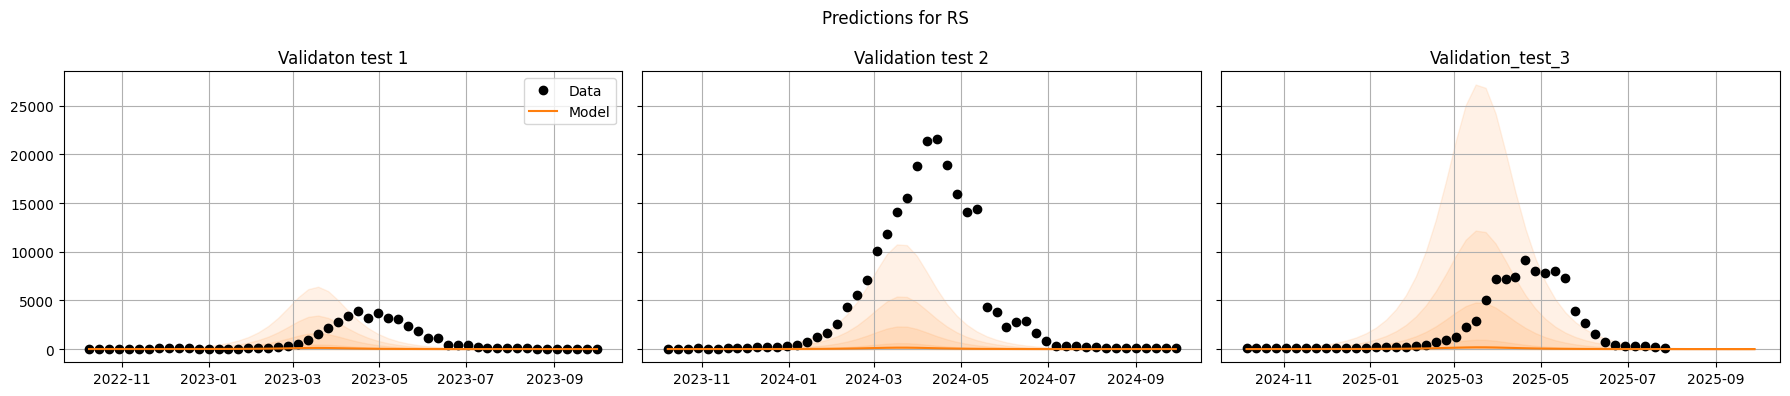

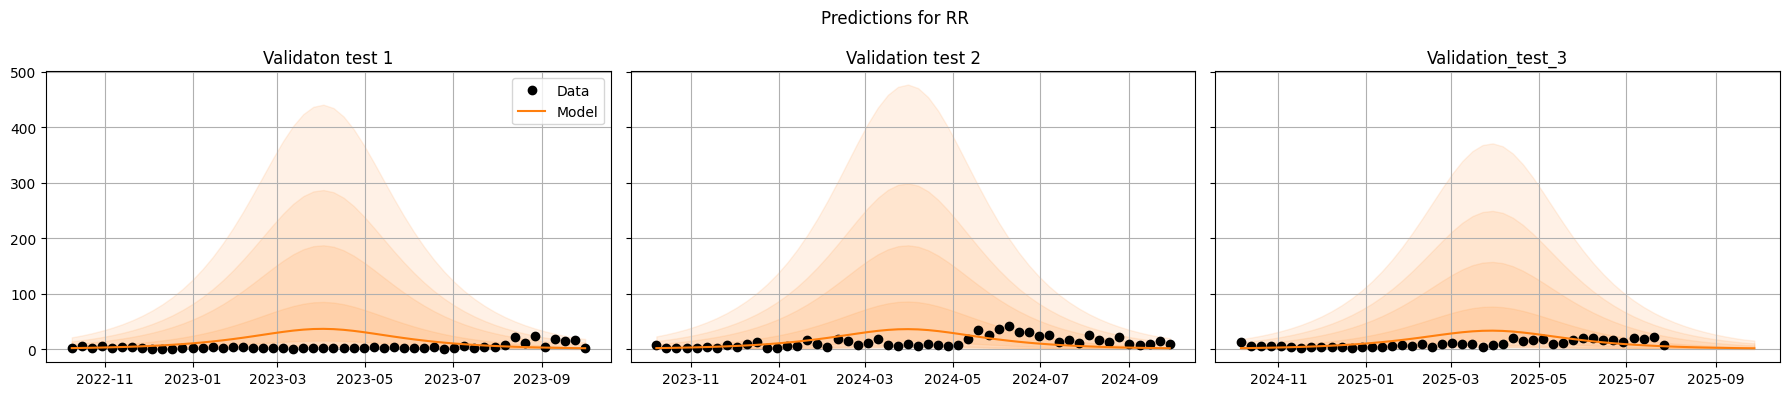

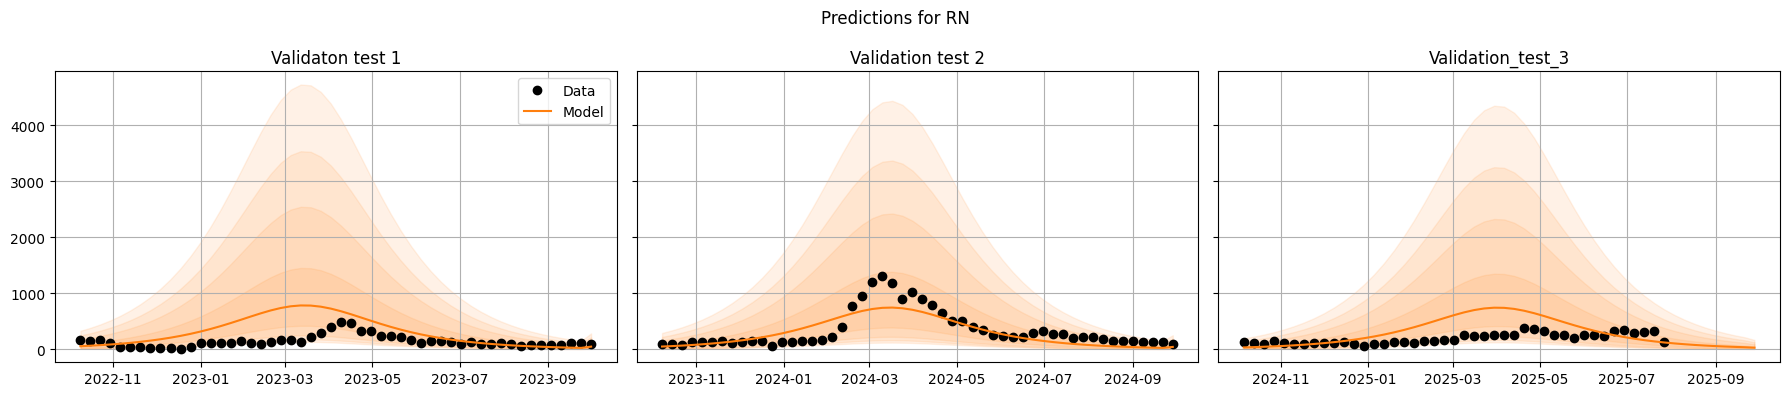

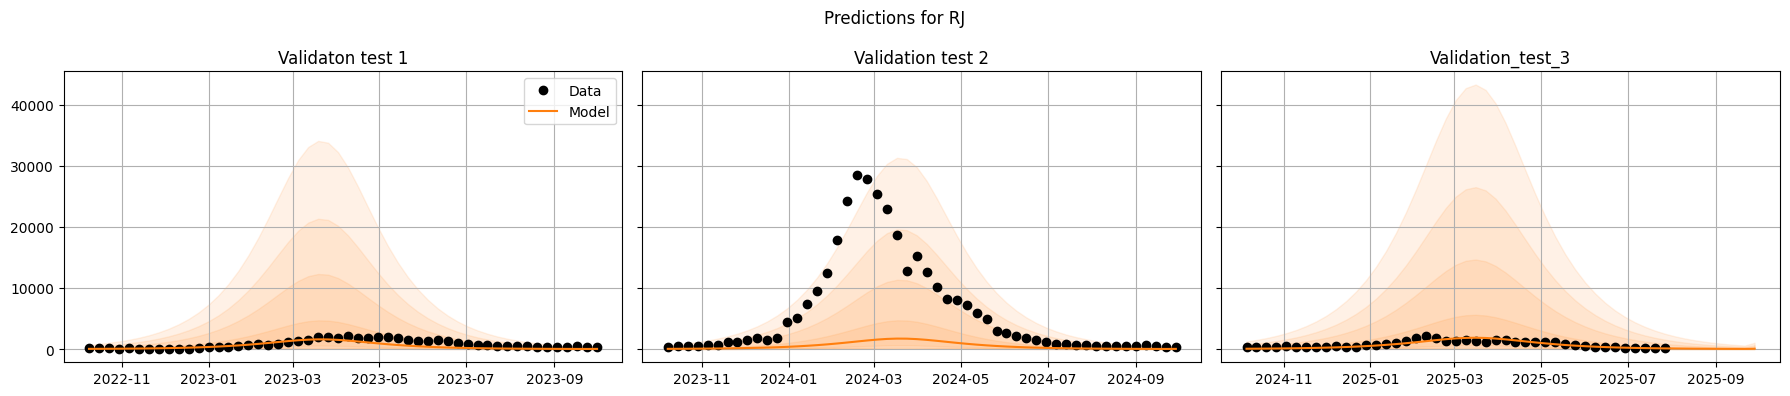

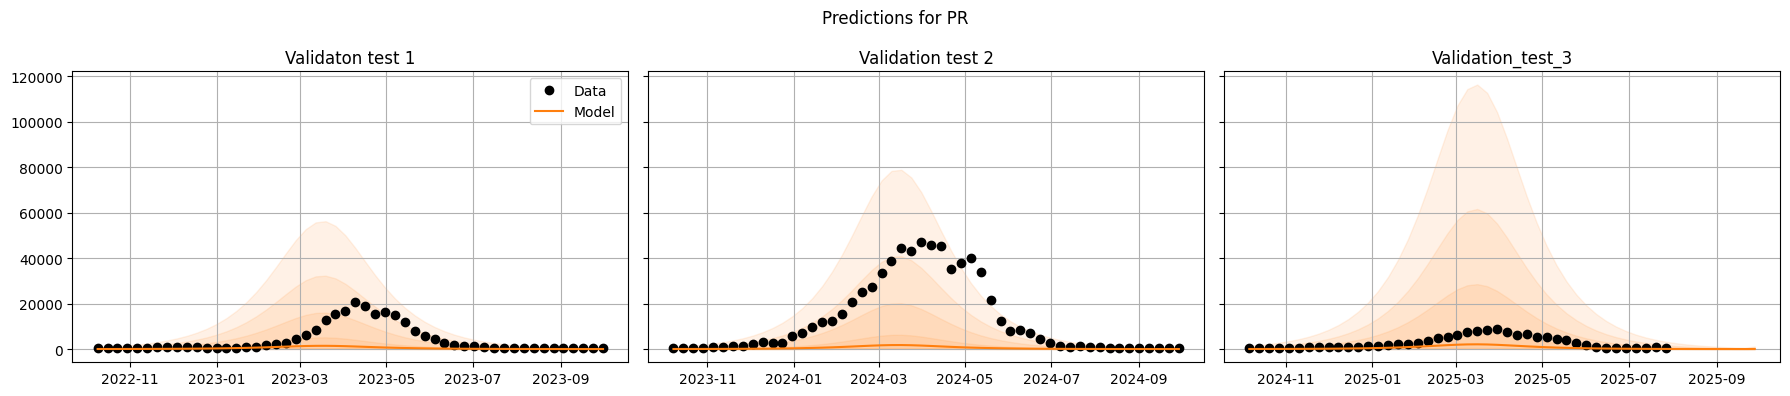

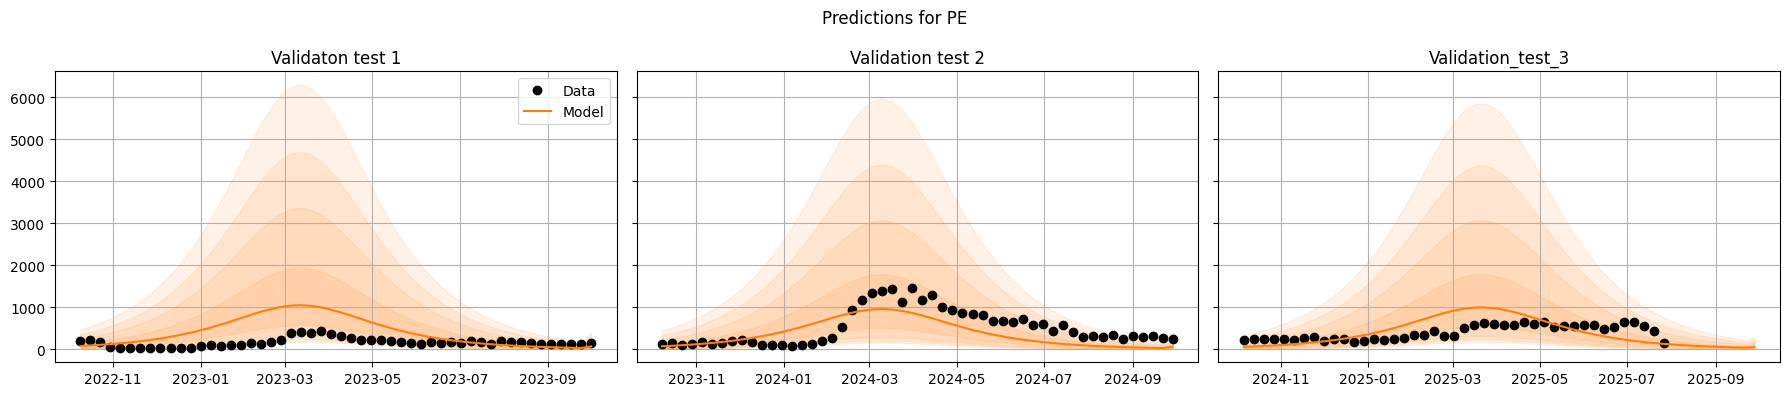

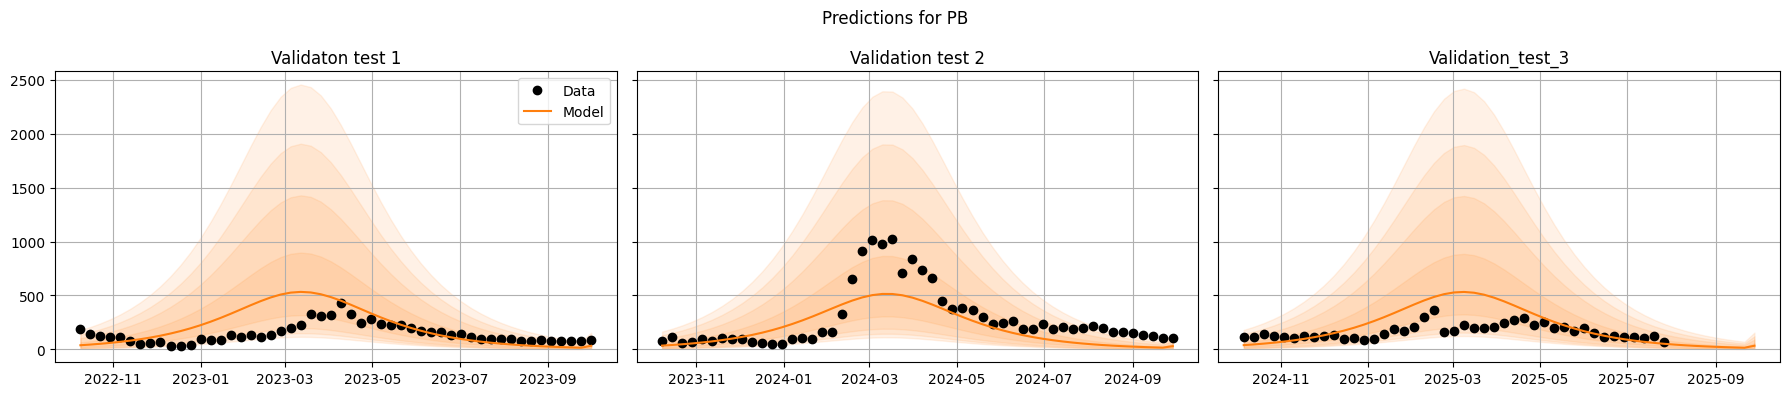

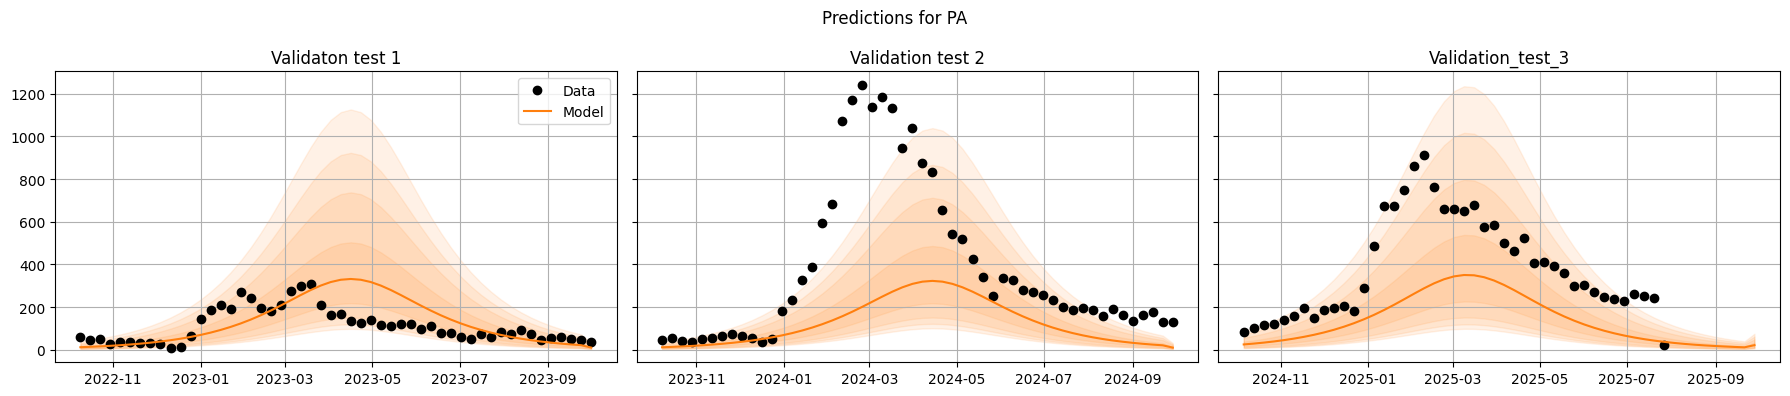

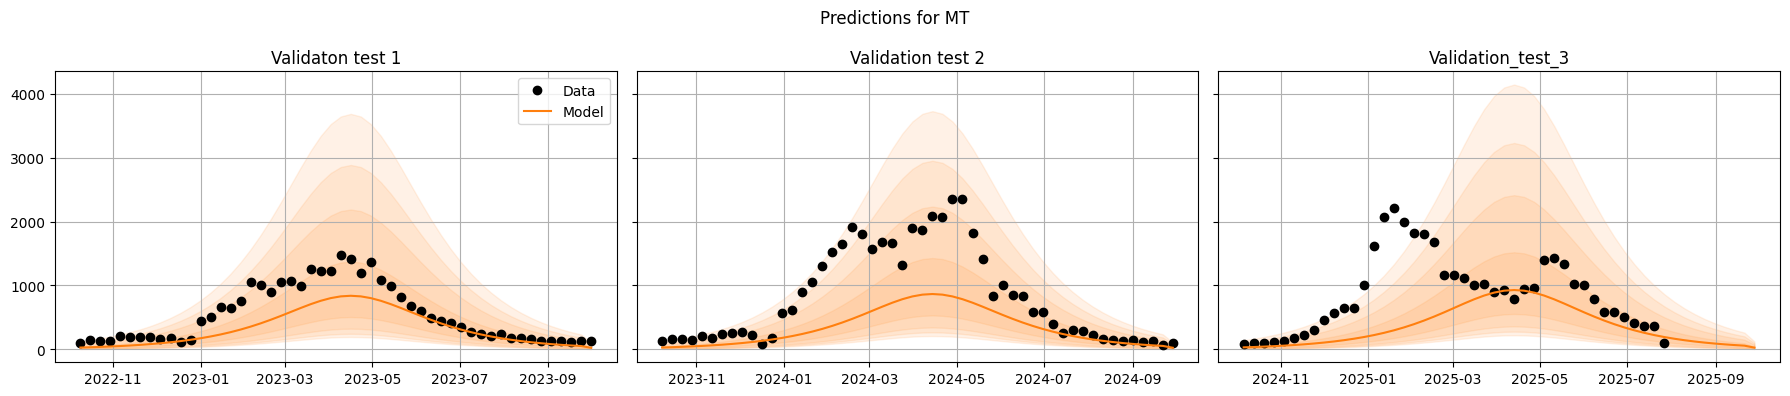

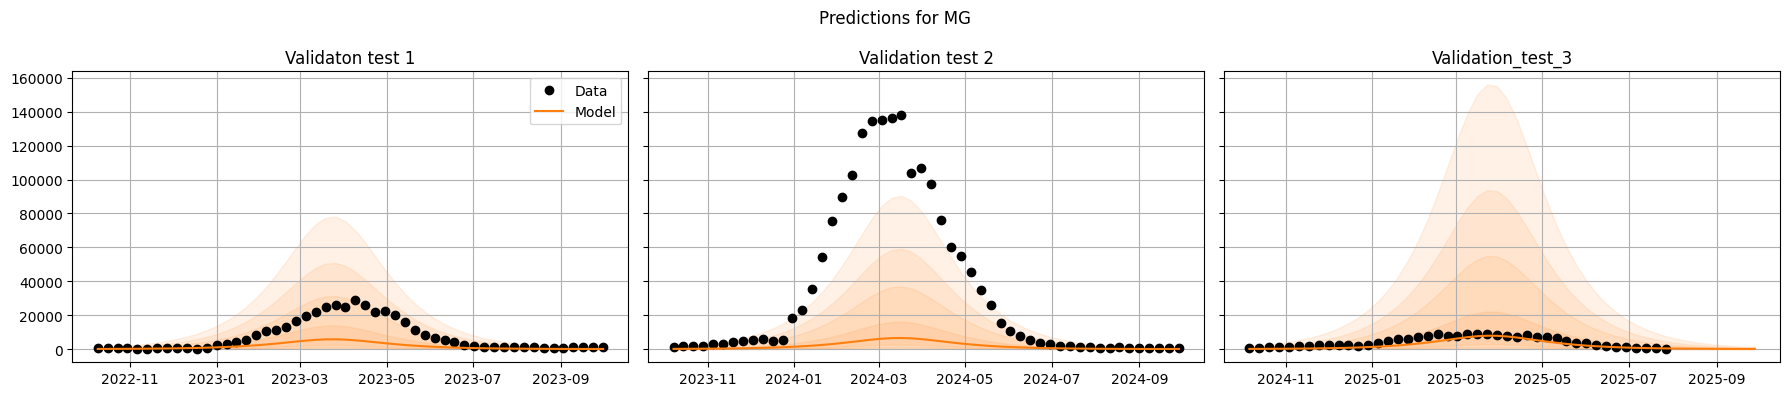

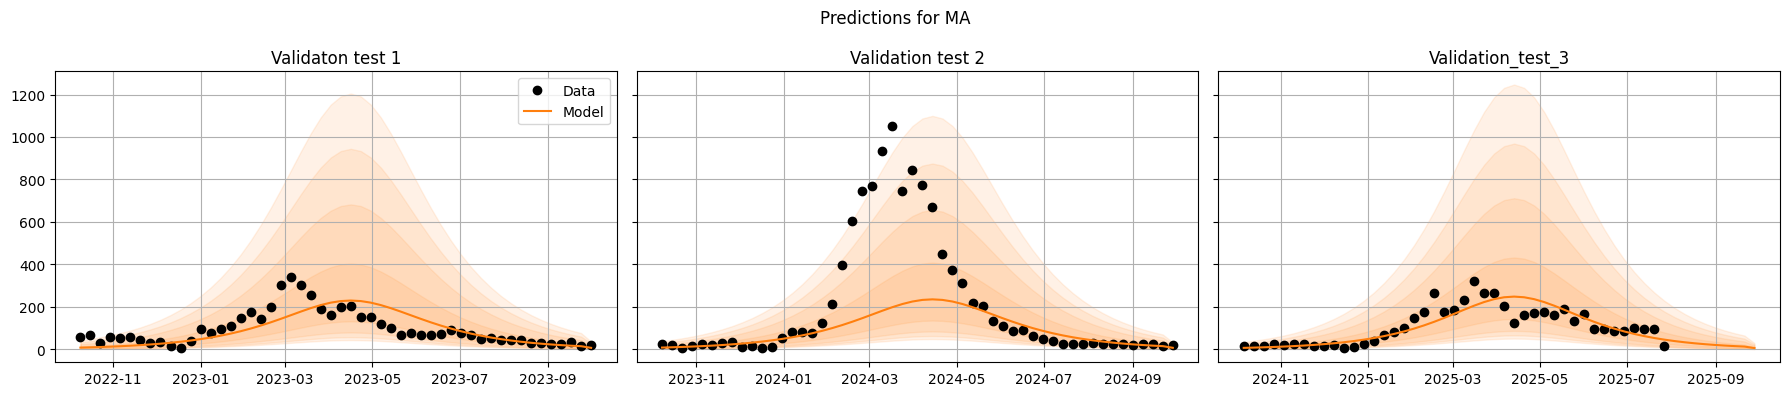

In [ ]:
for state in df_valid.state.unique():
    plot_by_state(state= state)